# Boilerplate

Just load packages:

In [1]:
import copy
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp

from sequence_jacobian import het, simple, create_model              # functions
from sequence_jacobian import interpolate, grids, misc, estimation   # modules
from numba import vectorize

This block does bissection, i.e. given a function $f$ and values $a$ and $b$ such that $f(a)$ and $f(b)$ have different signs, we find a root. The function `bissection_onestep` does one step of bissection: given two values $a$ and $b$, it returns new values for $a$ and $b$ that bracket the root. The function `vec_bissection` applies the function `bissection_onestep` until the distance between $a$ and $b$ is small (or we run out of iterations). 

This is relatively slow, but safe method (and easy to implement!) to find a root. We only use it to find the value for consumption when the minimum asset constrain is binding. 

The function is written to receive a function that returns an array, each element of the array represents a point in the grids of the state variables:

In [2]:
def bissection_onestep(f,a,b):
    if not np.all(f(a)*f(b) <= 0):
        raise ValueError("No sign change")
    else:
        mid_point = (a + b)/2
        mid_value = f(mid_point)
        new_a = a
        new_b = b
        indxs_a = np.nonzero(mid_value*f(b) <= 0)
        indxs_b = np.nonzero(mid_value*f(a) <= 0)
        if indxs_a[0].size != 0:
            new_a[indxs_a] = mid_point[indxs_a]
        if indxs_b[0].size != 0:
            new_b[indxs_b] = mid_point[indxs_b]
        return new_a,new_b

def vec_bissection(f,a,b,iter_max = 100,tol = 1E-11):
    i = 1
    err = 1
    while i < iter_max and err > tol:
        a,b = bissection_onestep(f,a,b)
        err = np.max(np.abs(a - b))
        i += 1
    if i >= iter_max:
        raise Error("No convergence")
    return a

# Asset Constrain: Binding situation

The usual household problem is:


$$
\max_{c_t,n_t,b_{t+1}} \sum_{t=1}^{\infty} \beta^t E_{t-1} \left[\left(\frac{c_t^{1-\gamma}}{1-\gamma} - \varphi \frac{n_t^{1+v}}{1+v}\right)\right] \text{ subject to } c_t + b_{t+1} = (1+r_t)b_t + w_t e_t n_t + T_t
$$

When the household minimum asset constrain is binding, $b_{t+1} = \underline{b}$, which changes the problem to:

$$
\max_{c_t,n_t} \sum_{t=1}^{\infty} \beta^t E_{t-1} \left[\left(\frac{c_t^{1-\gamma}}{1-\gamma} - \varphi \frac{n_t^{1+v}}{1+v}\right)\right] \text{ subject to } c_t + \underline{b} = (1+r_t)b_t + w_t e_t n_t + T_t
$$

This breaks down the intertemporal problem. The lagrangian for this problem is:

$$
\mathcal{L} = \sum_{t=1}^{\infty} \beta^t \left(\frac{c_t^{1-\gamma}}{1-\gamma} - \varphi \frac{n_t^{1+v}}{1+v}\right) -\lambda(c_t + \underline{b} - (1+r_t)b_t - w_t e_t n_t - T_t)
$$

$$
\frac{\partial \mathcal{L}}{\partial c_t} = \beta^t c_t^{-\gamma} - \lambda = 0 \quad (i)\\
\frac{\partial \mathcal{L}}{\partial n_t} = -\beta^t \varphi n_t^{v} + \lambda w_t e_t = 0 \quad (ii)
$$

Working with (i):

$$
\beta^t c_t^{-\gamma} = \lambda
$$

Plug it into (ii):

$$
\beta^t \varphi n_t^{v} = \beta^t c_t^{-\gamma} w_t e_t \\
n_t = \left(\frac{w_t e_t}{\varphi c_t^{\gamma}}\right)^{1/v}
$$

Since any solution needs to respect the constrain:

$$
c_t + \underline{b} = w_t e_t\left(\frac{w_t e_t}{\varphi c_t^{\gamma}}\right)^{1/v} + (1+r_t)b_t + T_t
$$

The function `consumption` implements the equation above. We are calling $(1+r_t) b_t + T_t - \underline{b}$ the `rest`; `we` is the product $w_t e_t$. Any value of $c$ that makes the equation above valid solves the constrained problem of the agent. We use the bissection functions of the previous section to do that:

In [3]:
def consumption(c,we,rest,gamma,v,phi):
    return c - we*(we/(phi*c**gamma))**(1/v) - rest

# Household block

This is the block that implements the household problem. We use the Endogenous Grid Method. When the value of the assets is bellow the minimum value $\underline{b}$, then we have to use the function of the previous section. 

The first function will simply give a guess to start the iteration:

In [4]:
def household_guess(a_grid,e_grid,r,w,gamma,T):
    wel = (1+r)*a_grid[np.newaxis,:] + w*e_grid[:,np.newaxis] + T[:,np.newaxis]
    V_prime = (1+r)*(wel*0.1)**(-gamma)
    return V_prime

The function bellow implements _one step_ of the solution of the household problem. The household problem is:

$$
\max_{c_t,n_t,b_{t+1}} \sum_{t=1}^{\infty} \beta^t E_{t-1} \left[\left(\frac{c_t^{1-\gamma}}{1-\gamma} - \varphi \frac{n_t^{1+v}}{1+v}\right)\right] \text{ subject to } c_t + b_{t+1} = (1+r_t)b_t + w_t e_t n_t + T_t
$$

In value function form:

$$
V_t(b_t) = \max_{c_t,n_t,b_{t+1}} \left(\frac{c_t^{1-\gamma}}{1-\gamma} - \varphi \frac{n_t^{1+v}}{1+v}\right) + \beta E_t[V_t(b_{t+1})]
$$

The problem above is subject to $c_t + b_{t+1} = (1+r_t)b_t + w_t e_t n_t + T_t$. Then:

$$
V_t(b_t) = \max_{n_t,b_{t+1}} \left(\frac{((1+r_t)b_t + w_t e_t n_t + T_t - b_{t+1})^{1-\gamma}}{1-\gamma} - \varphi \frac{n_t^{1-v}}{1-v}\right) + \beta E_t[V_t(b_{t+1})]
$$

Then:

$$
\frac{\partial V}{\partial b_{t+1}} = -((1+r_t)b_t + w_t e_t n_t + T_t - b_{t+1})^{-\gamma} + \beta E_t\left[\frac{\partial V}{\partial b_{t+1}}\right]\\
\frac{\partial V}{\partial n_{t}} = w_t e_t((1+r_t)b_t + w_t e_t n_t + T_t - b_{t+1})^{-\gamma} - \phi n_t^{v}\\
\frac{\partial V}{\partial b_t} = (1+r_t)((1+r_t)b_t + w_t e_t n_t + T_t - b_{t+1})^{-\gamma}
\tag{foc}
$$

By Benveniste Scheinkman, we have that:

$$\frac{\partial V}{\partial b_{t+1}} = (1+r_{t+1})(c_{t+1})^{-\gamma} \tag{a}$$

This will be the variable `V_prime_p` in the problem bellow.

Joining the first and the last expression of the block above, and using that $c_t = (1+r_t)b_t + w_t e_t n_t + T_t - b_{t+1}$, we have, in the point of maximum:

$$
-c_t^{-\gamma} + \beta(1+r_{t+1})(c_{t+1})^{-\gamma} = 0\\
c_t = (\beta(1+r_{t+1})(c_{t+1})^{-\gamma})^{-1/\gamma}
$$

This gives the value of the policy ($c_t$) in the current iteration. We can obtain it in terms of $\frac{\partial V}{\partial b_t}$ from (a) as $c_t = \left(\beta \frac{\partial V}{\partial b_{t+1}} \right)^{-1/\gamma}$. This is the definition of `c_prime`.

Using the second equation from the foc block, we obtain:

$$
n_t = \left(\frac{e_t w_t}{\varphi c_t^{\gamma}}\right)^{1/v}
$$

This is the variable `n_prime`. 

By the budget constrain:

$$
b_{t+1} + c_t = (1+r_t)b_t + e_t w_t n_t + T_t
$$

If we have a grid of today values of the asset `a_grid`, then the values implied by the budget constrain of the asset tomorrow are $c_t + b_{t+1} - w_t e_t n_t - T_t$. This is the variable `new_grid`. We interpolate from these values to obtain the value of the variables $c_t$ and $n_t$. 

We then compute the assets of the next period that this policy implies. If the policy implies an asset value smaller than the minimum allowed, we then need to compute the best value of consumption given that it is constrained. We then use the calculations of the previous section to do that.  

In [5]:
@het(exogenous = 'Pi',policy = 'a', backward = 'V_prime', backward_init=household_guess)
def household(V_prime_p,a_grid,e_grid,r,w,T,beta,gamma,v,phi):

    we = w*e_grid

    c_prime = (beta*V_prime_p)**(-1/gamma) #c_prime is quite a misnomer, since this is the new guess for c_t
    n_prime = (we[:,np.newaxis]/(phi*c_prime**gamma))**(1/v)

    new_grid = (c_prime + a_grid[np.newaxis,:] - we[:,np.newaxis]*n_prime - T[:,np.newaxis])
    wel = (1+r)*a_grid

    c = interpolate.interpolate_y(new_grid,wel,c_prime)
    n = interpolate.interpolate_y(new_grid,wel,n_prime)

    a = wel + we[:,np.newaxis]*n + T[:,np.newaxis] - c
    V_prime= (1+r)*c**(-gamma)

    # checks for violations of the condition of minimal assets required and fixes it

    indexes_asset = np.nonzero(a < a_grid[0]) #first dimension: labor grid, second dimension: asset grid
    a[indexes_asset] = a_grid[0]

    if indexes_asset[0].size != 0 and indexes_asset[1].size !=0:

        aa = np.zeros((indexes_asset[0].size)) + 1E-5
        rest = -a_grid[0] + wel[indexes_asset[1]] + T[indexes_asset[0]]
        bb = c[indexes_asset] + 0.5
        
        c[indexes_asset] = vec_bissection(lambda c : consumption(c,we[indexes_asset[0]],rest,gamma,v,phi),aa,bb)
        n[indexes_asset] = (we[indexes_asset[0]]/(phi*c[indexes_asset]**gamma))**(1/v)
        V_prime[indexes_asset] = (1+r)*(c[indexes_asset])**(-gamma)

    return V_prime,a,c,n

print(household)
print(f'Inputs: {household.inputs}')
print(f'Macro outputs: {household.outputs}')
print(f'Micro outputs: {household.internals}')

<HetBlock 'household'>
Inputs: ['a_grid', 'e_grid', 'r', 'w', 'T', 'beta', 'gamma', 'v', 'phi', 'Pi']
Macro outputs: ['A', 'C', 'N']
Micro outputs: ['D', 'Dbeg', 'Pi', 'V_prime', 'a', 'c', 'n']


The rest of the code is identical to the HANK example in their notebook on their repo:

In [43]:
def make_grid(rho_e, sd_e, nE, amin, amax, nA):
    e_grid, pi_e, Pi = grids.markov_rouwenhorst(rho=rho_e, sigma=sd_e, N=nE)
    a_grid = grids.agrid(amin=amin, amax=amax, n=nA)
    return e_grid, Pi, a_grid, pi_e

def transfers(pi_e, Div, Transfer, e_grid):
    # hardwired incidence rules are proportional to skill; scale does not matter 
    tax_rule, div_rule = np.ones(e_grid.size), e_grid
    div = Div / np.sum(pi_e * div_rule) * div_rule
    transfer =  Transfer / np.sum(pi_e * tax_rule) * tax_rule 
    T = div + transfer
    return T

household_inp= household.add_hetinputs([make_grid,transfers])

print(household_inp)
print(f'Inputs: {household_inp.inputs}')

<HetBlock 'household' with hetinput 'make_grid_transfers'>
Inputs: ['r', 'w', 'beta', 'gamma', 'v', 'phi', 'rho_e', 'sd_e', 'nE', 'amin', 'amax', 'nA', 'Div', 'Transfer']


In [44]:
def labor_supply(n, e_grid):
    ne = e_grid[:, np.newaxis] * n
    return ne

hh_ext = household_inp.add_hetoutputs([labor_supply])

print(hh_ext)
print(f'Outputs: {hh_ext.outputs}')
print(f'Inputs: {household_inp.inputs}')

<HetBlock 'household' with hetinput 'make_grid_transfers' and with hetoutput `labor_supply'>
Outputs: ['A', 'C', 'N', 'NE']
Inputs: ['r', 'w', 'beta', 'gamma', 'v', 'phi', 'rho_e', 'sd_e', 'nE', 'amin', 'amax', 'nA', 'Div', 'Transfer']


In [119]:
@simple
def firm(Y, w, Z, pi, mu, kappa):
    L = Y / Z
    Div = Y - w * L - mu/(mu-1)/(2*kappa) * (1+pi).apply(np.log)**2 * Y
    return L, Div


@simple
def monetary(pi, rstar, phi_pi):
    i = (rstar(-1))
    r =  (1+i) / (1 + pi) - 1
    return r,i


@simple
def fiscal(r,Transfer, Tstar,A):
    B = (1+r)*A(-1) + Transfer + Tstar #can't reference B(-1) because it is being defined here. No problem, since A = B (??)
    return B


@simple
def mkt_clearing(A, NE, C, L, Y, B, pi, mu, kappa):
    asset_mkt = A - B
    labor_mkt = NE - L
    goods_mkt = Y - C - mu/(mu-1)/(2*kappa) * (1+pi).apply(np.log)**2 * Y
    return asset_mkt, labor_mkt, goods_mkt


@simple
def nkpc_ss(Z, mu):
    w = Z / mu
    return w

In [120]:
blocks_ss = [hh_ext, firm, monetary,fiscal, nkpc_ss, mkt_clearing]

hank_ss = create_model(blocks_ss, name="One-Asset HANK SS")

print(hank_ss)
print(f"Inputs: {hank_ss.inputs}")
print(f"Outputs: {hank_ss.outputs}")

<Model 'One-Asset HANK SS'>
Inputs: ['beta', 'gamma', 'v', 'phi', 'rho_e', 'sd_e', 'nE', 'amin', 'amax', 'nA', 'Transfer', 'Y', 'Z', 'pi', 'mu', 'kappa', 'rstar', 'phi_pi', 'Tstar']
Outputs: ['A', 'C', 'N', 'NE', 'L', 'Div', 'r', 'i', 'B', 'w', 'asset_mkt', 'labor_mkt', 'goods_mkt']


In [121]:
calibration = {'gamma': 1, 'v': 1, 'rho_e': 0.966, 'sd_e': 0.5, 'nE': 7,
               'amin': 0, 'amax': 150, 'nA': 500, 'Y': 1.0, 'Z': 1.0, 'pi': 0.0,
               'mu': 1.2, 'kappa': 0.1, 'rstar': 0.005, 'phi_pi': 1.5,'Transfer':-0.03, 'Tstar': 0}

unknowns_ss = {'beta': 0.986, 'phi': 0.8}
targets_ss = {'asset_mkt': 0, 'labor_mkt': 0}

ss0 = hank_ss.solve_steady_state(calibration, unknowns_ss, targets_ss, solver="hybr")

In [122]:
print(f"Asset market clearing: {ss0['asset_mkt']: 0.2e}")
print(f"Labor market clearing: {ss0['labor_mkt']: 0.2e}")
print(f"Goods market clearing (untargeted): {ss0['goods_mkt']: 0.2e}")

Asset market clearing:  8.88e-15
Labor market clearing: -6.77e-15
Goods market clearing (untargeted): -4.17e-09


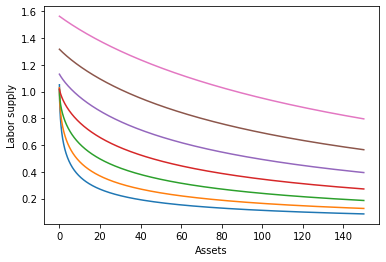

In [123]:
plt.plot(ss0.internals['household']['a_grid'], ss0.internals['household']['n'].T)
plt.xlabel('Assets'), plt.ylabel('Labor supply')
plt.show()

In [124]:
@simple
def nkpc(pi, w, Z, Y, r, mu, kappa):
    nkpc_res = kappa * (w / Z - 1 / mu) + Y(+1) / Y * (1 + pi(+1)).apply(np.log) / (1 + r(+1))\
               - (1 + pi).apply(np.log)
    return nkpc_res


blocks = [hh_ext, firm, monetary, fiscal, mkt_clearing, nkpc]
hank = create_model(blocks, name="One-Asset HANK")

print(*hank.blocks, sep='\n')

<SimpleBlock 'monetary'>
<SimpleBlock 'nkpc'>
<SimpleBlock 'firm'>
<HetBlock 'household' with hetinput 'make_grid_transfers' and with hetoutput `labor_supply'>
<SimpleBlock 'fiscal'>
<SimpleBlock 'mkt_clearing'>


In [125]:
ss = hank.steady_state(ss0)

for k in ss0.keys():
    assert np.all(np.isclose(ss[k], ss0[k]))

In [126]:
T = 300
exogenous = ['rstar','Tstar', 'Z']
unknowns = ['pi', 'w', 'Y']
targets = ['nkpc_res', 'asset_mkt', 'labor_mkt']

# general equilibrium jacobians
G = hank.solve_jacobian(ss, unknowns, targets, exogenous, T=T)

print(G)

<JacobianDict outputs=['pi', 'w', 'Y', 'A', 'C', 'N', 'NE', 'L', 'Div', 'r', 'i', 'B', 'asset_mkt', 'labor_mkt', 'goods_mkt', 'nkpc_res'], inputs=['rstar', 'Tstar', 'Z']>


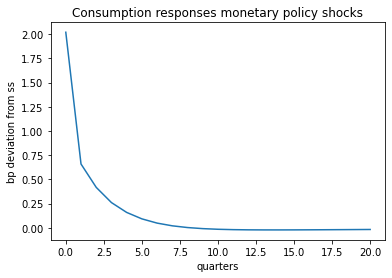

In [148]:
rhos = np.array([0])

dtstar = 0.0162 * rhos ** (np.arange(T)[:, np.newaxis])
dpi = (G['C']['Tstar']) @ dtstar

plt.plot(1000*dpi[:21])
plt.title(r'Consumption responses monetary policy shocks')
plt.xlabel('quarters')
plt.ylabel('bp deviation from ss')
plt.show()

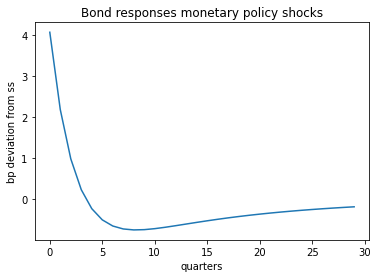

In [150]:
dpi = G['A']['Tstar'] @ dtstar

plt.plot(1000*dpi[:30])
plt.title(r'Bond responses monetary policy shocks')
plt.xlabel('quarters')
plt.ylabel('bp deviation from ss')
plt.show()

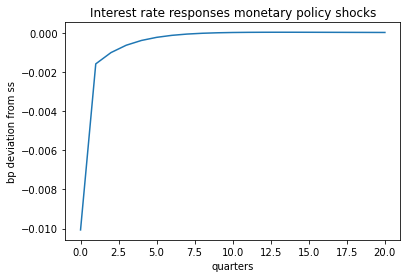

In [155]:
dpi = (G['r']['Tstar'] + + G['pi']['Tstar']) @ dtstar

plt.plot(1000*dpi[:21])
plt.title(r'Interest rate responses monetary policy shocks')
plt.xlabel('quarters')
plt.ylabel('bp deviation from ss')
plt.show()

# Model with fiscal shock

_Ad hoc_, adds a `T_star` to the tax rule. 

In [43]:
@simple
def firm(Y, w, Z, pi, mu, kappa):
    L = Y / Z
    Div = Y - w * L - mu/(mu-1)/(2*kappa) * (1+pi).apply(np.log)**2 * Y
    return L, Div


@simple
def monetary(pi, rstar, phi_pi):
    r = (1 + rstar(-1) + phi_pi * pi(-1)) / (1 + pi) - 1
    return r


@simple
def fiscal(r, B,T_star):
    Tax = r * B - T_star(-1)
    return Tax


@simple
def mkt_clearing(A, NE, C, L, Y, B, pi, mu, kappa):
    asset_mkt = A - B
    labor_mkt = NE - L
    goods_mkt = Y - C - mu/(mu-1)/(2*kappa) * (1+pi).apply(np.log)**2 * Y
    return asset_mkt, labor_mkt, goods_mkt


@simple
def nkpc(pi, w, Z, Y, r, mu, kappa):
    nkpc_res = kappa * (w / Z - 1 / mu) + Y(+1) / Y * (1 + pi(+1)).apply(np.log) / (1 + r(+1))\
               - (1 + pi).apply(np.log)
    return nkpc_res


blocks = [hh_ext, firm, monetary, fiscal, mkt_clearing, nkpc]
hank = create_model(blocks, name="One-Asset HANK")

calibration = {'gamma': 1, 'v': 1, 'rho_e': 0.966, 'sd_e': 0.5, 'nE': 7,
               'amin': 0, 'amax': 150, 'nA': 500, 'Y': 1.0, 'Z': 1.0, 'pi': 0.0,
               'mu': 1.2, 'kappa': 0.1, 'rstar': 0.005, 'phi_pi': 1.5, 'B': 5.6, 'T_star': 0.0}

unknowns_ss = {'beta': 0.986, 'phi': 0.8}
targets_ss = {'asset_mkt': 0, 'labor_mkt': 0}

ss0 = hank_ss.solve_steady_state(calibration, unknowns_ss, targets_ss, solver="hybr")

ss = hank.steady_state(ss0)

for k in ss0.keys():
    assert np.all(np.isclose(ss[k], ss0[k]))
    
T = 300
exogenous = ['rstar', 'Z','T_star']
unknowns = ['pi', 'w', 'Y']
targets = ['nkpc_res', 'asset_mkt', 'labor_mkt']

# general equilibrium jacobians
G = hank.solve_jacobian(ss, unknowns, targets, exogenous, T=T)

print(G)

<JacobianDict outputs=['pi', 'w', 'Y', 'A', 'C', 'N', 'NE', 'L', 'Div', 'r', 'Tax', 'asset_mkt', 'labor_mkt', 'goods_mkt', 'nkpc_res'], inputs=['rstar', 'Z', 'T_star']>


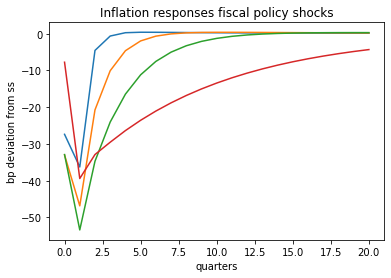

In [45]:
rhos = np.array([0.2,0.5, 0.7, 0.9])

dtstar = 0.05*rhos ** (np.arange(T)[:, np.newaxis])
drstar = 0.0025 * rhos ** (np.arange(T)[:, np.newaxis])

dpi = G['pi']['T_star'] @ dtstar

plt.plot(10000 * dpi[:21])
plt.title(r'Inflation responses fiscal policy shocks')
plt.xlabel('quarters')
plt.ylabel('bp deviation from ss')
plt.show()

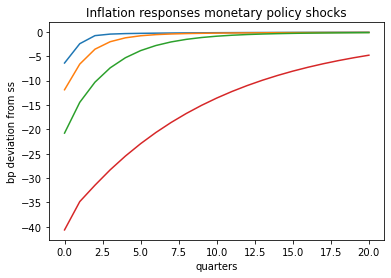

In [46]:
dpi = G['pi']['rstar'] @ drstar

plt.plot(10000*dpi[:21])
plt.title(r'Inflation responses monetary policy shocks')
plt.xlabel('quarters')
plt.ylabel('bp deviation from ss')
plt.show()

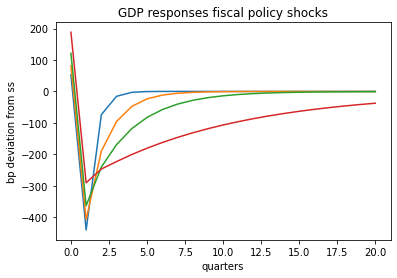

In [47]:
dpi = G['Y']['T_star'] @ dtstar

plt.plot(10000 * dpi[:21])
plt.title(r'GDP responses fiscal policy shocks')
plt.xlabel('quarters')
plt.ylabel('bp deviation from ss')
plt.show()

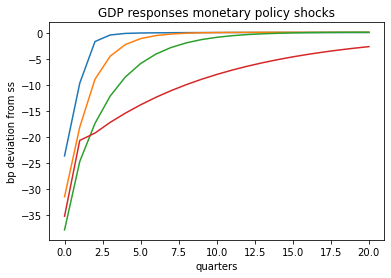

In [24]:
dpi = G['Y']['rstar'] @ drstar

plt.plot(10000 * dpi[:21])
plt.title(r'GDP responses monetary policy shocks')
plt.xlabel('quarters')
plt.ylabel('bp deviation from ss')
plt.show()

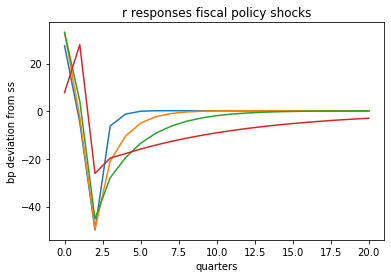

In [48]:
dpi = G['r']['T_star'] @ dtstar

plt.plot(10000 * dpi[:21])
plt.title(r'r responses fiscal policy shocks')
plt.xlabel('quarters')
plt.ylabel('bp deviation from ss')
plt.show()

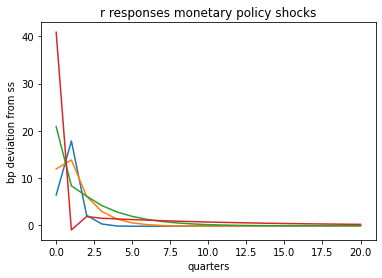

In [27]:
dpi = G['r']['rstar'] @ drstar

plt.plot(10000 * dpi[:21])
plt.title(r'r responses monetary policy shocks')
plt.xlabel('quarters')
plt.ylabel('bp deviation from ss')
plt.show()